# General Description

This notebook uses R code, please make sure an R kernel is installed for your jupyter notebook or copy the code and run it in an R environment.

This notebook describes the steps for:
* reading in input flies
* converting CellPhoneDB output (significant_means.txt  file) into a weight array
* Ligand-Receptor Pair Clustering

The **input** for this notebook is 
* significant_means.txt from "cpdb_output" folder 
* complex_input.csv obtained from CellPhoneDB site
* gene_input.csv obtained from CellPhoneDB site

The **output** of this notebook is:

* intercations variable that contains:
    * weight_array: array of weighted adjacency matrices (#nodes x #nodes x #ligand-receptor pairs)
    * ligandReceptorPairDF: dataframe of ligand-receptor pairs with columns: 
		* "pair" contains values in a form "ligand:receptor", i.e. ligand being at the first place, receptor being at the second place, e.g. "TNFSF13:TNFRSF17"
		*  "ligand" contains ligand names, e.g. "TNFSF13"
		* "ligand_complex_composition" if ligand is a complex (e.g. "aXb2_complex"), contains genes in the ligand complex separated with a comma, e.g. "ITGAX,ITGB2", else contains ""
		* "receptor" contains receptor names, e.g. "TNFRSF17"
		* "receptor_complex_composition" if receptor is a complex (e.g. "NKG2D_II_receptor"), contains genes in the receptor complex separated with a comma, e.g. "KLRK1,HCST", else contains ""
	* nodes: cell types
    

* lrp_clusters variable that contains:
	* dissim_matrix: dissimilarity matrix
	* clusters: cluster assignment for each ligand-receptor pair
	* weight_array_byCluster: array of weighted adjacency matrices of clusters (#nodes x #nodes x #clusters). Each weighted adjacency matrix contains average edge weights among ligand-receptor pairs in a cluster.
	* degree_array_byCluster: array of node degrees (#nodes x 3 (in, out , delta) x # clusters). Each each degree matrix contains average -in , -out, and -delta node degree values among ligand-receptor pairs in a cluster.

# COMUNET analysis

## Libraries:

In [1]:
# libraries ####
require(COMUNET)
require(dynamicTreeCut) # cuts the hierarchical tree into clusters
require(ComplexHeatmap) # heatmaps
require(umap) # for umap of ligand-receptor pairs
require(igraph) # plot individual networks
require(SDMTools) # for gradient legend in graph
require(ggplot2)
# end libraries

Loading required package: COMUNET

Loading required package: dynamicTreeCut

Loading required package: ComplexHeatmap

Loading required package: grid

ComplexHeatmap version 1.20.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://bioconductor.org/packages/ComplexHeatmap/

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.


Loading required package: umap

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: SDMTools

Loading required package: ggplot2



## Options

In [2]:
options(stringsAsFactors = F)

## Input variables

### Paths

If you are using CellPhoneDB, please additionally download (to your working directory) gene_input.csv and complex_input.csv from the [CellPhoneDB site](https://www.cellphonedb.org/downloads).

In [3]:
main.path <- getwd() # current working directory
input.path <- paste0(main.path
                    ,"/cpdb_output") # CellPhoneDB output folder
outputPath = paste0(main.path
                    ,"/comunet_output")

# Please make sure, the complex_input.csv and gene_input.csv are downloaded to your working directory
complex_input <- paste0(main.path
                        ,"/complex_input.csv"
)
gene_input <- paste0(main.path
                     ,"/gene_input.csv"
                     )

### Read in data

For the analysis, we will need to read in following data: complex_input and gene_input (since we are using CellPhoneDB), as well as normalised count matrix and annotation matrix for both conditions.

In [4]:
# complex input
complex_input <- read.csv(complex_input)
complex_input$complex_name <- gsub("_"
                                   ," "
                                   ,complex_input$complex_name)

# gene input
gene_input <- read.csv(gene_input)

### Read in CellPhoneDB output

We also need to read in the weight matrices for both conditions. In this case, our weight matrices (significant_means.txt) are produced by CellPhoneDB.

In [5]:
# read in CellPhoneDB output
CellPhoneDB_output <- read.csv(paste0(input.path
                                      ,"/significant_means.txt")
                               ,sep = "\t"
                               ,check.names = F)

# delete duplicates
CellPhoneDB_output <- CellPhoneDB_output[!duplicated(CellPhoneDB_output$interacting_pair),]

# add row names (interacting pairs)
rownames(CellPhoneDB_output) <- CellPhoneDB_output$interacting_pair

# transform 'receptor_a' colomn into boolean
CellPhoneDB_output$receptor_a  <- sapply(CellPhoneDB_output$receptor_a
                                         ,function(i){
                                           if(i == "True") T else F
                                         }
)

# transform 'receptor_b' colomn into boolean
CellPhoneDB_output$receptor_b  <- sapply(CellPhoneDB_output$receptor_b
                                         ,function(i){
                                           if(i == "True") T else F
                                         }
)

## Convert CellPhoneDB output 

In this step, we will transform the CellPhoneDB weight matrix into a COMUNET format. The CellPhoneDB weight matrix (significant_means.txt) contains ligand-receptor pairs in the rows and all pairs of cell types in the columns. COMUNET transforms it into a stack of weight matrices (i.e. weight array), one weight matrix per ligand-receptor pair. If CellPhoneDB output contains $m$ non-empty ligand-receptor pairs, then the number of matrices in the stack will be equal to $m$. Each such weight matrix has all cell types in the rows and all cell types in the columns. So if there are $n$ cell types in the data, each weight matrix is an $n \times n$ matrix. The rows of each matrix represent sending cell types, i.e. cell types that express a ligand of a ligand-receptor pair, or just partner A of an undirected interacting pair (e.g. pair of adhesion molecules). The columns of each matrix represent receiving cell types, i.e. cell types that express a receptor of a ligand-receptor pair, or partner B of an undirected interacting pair (e.g. pair of adhesion molecules). The NA values of the CellPhoneDB output are substituted with 0. 

In the language of network science, this stack of weight matrices represents a multiplex network with each matrix being one layer of the network. We regard thus each weight matrix as an adjacency matrix of a communication graph with weights representing the edges and cell types representing nodes. The higher the weight, the stronger the intensity of communication between the two cell types (nodes) that this edge connects. Each ligand-receptor pair thus gets its own communication graph in the multiplex network (i.e. one weight matrix in the weight matrix stack). For the analyses run on single-cell RNAseq, we want to underscore that one nodes represents a pool of cells, which all belong to the same cell type, and not a single cell. 

COMUNET can work with any kind of of weight matrices: expression-based weights, p-values, etc. The user can thus generate the weight matrices with any algorithm of choice and provide them to COMUNET in the format of a stack of weight matrices described above.

In case you use CellPhoneDB, we recommend to convert its output using the ```convert_CellPhoneDB_output``` function of COMUNET. The ```convert_CellPhoneDB_output``` function receives the CellPhoneDB weight matrix which we read in in the previous section, complex_input and gene_input, both of which we obtained from the [CellPhoneDB site](https://www.cellphonedb.org/downloads). The output of the ```convert_CellPhoneDB_output``` function is a list that contains:
* ```w_array``` stack of weight matrices
* ```ligand_receptor_pair_df``` data frame with columns "pair", "ligand", "ligand_complex_composition", "receptor", "receptor_complex_composition"
* ```nodes``` string vector that contains all cell types 

Note that  CellPhoneDB does not necessarily place ligand and receptors in the same order. Since COMUNET relies on the order and needs the ligand to be the first protein in the pair and the receptor the second, the ```convert_CellPhoneDB_output``` function will check the oder and swap the proteins automatically if needed. If the direction of signalling in a cell-cell communication event (e.g. integrins), the order of the interacting proteins is random.

In [6]:
interactions <- convert_CellPhoneDB_output(CellPhoneDB_output = CellPhoneDB_output
                                           ,complex_input = complex_input
                                           ,gene_input = gene_input)
print(str(interactions))

List of 3
 $ weight_array           : num [1:5, 1:5, 1:162] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:5] "EPI" "Mes" "TE" "emVE" ...
  .. ..$ : chr [1:5] "EPI" "Mes" "TE" "emVE" ...
  .. ..$ : chr [1:162] "WNT5A:FZD6" "NRG1:NETO2" "EFNB1:EPHB2" "EPHB2:EFNB3" ...
 $ ligand_receptor_pair_df:'data.frame':	162 obs. of  5 variables:
  ..$ pair                        : chr [1:162] "WNT5A:FZD6" "NRG1:NETO2" "EFNB1:EPHB2" "EPHB2:EFNB3" ...
  ..$ ligand                      : chr [1:162] "WNT5A" "NRG1" "EFNB1" "EPHB2" ...
  ..$ ligand_complex_composition  : chr [1:162] "WNT5A" "NRG1" "EFNB1" "EPHB2" ...
  ..$ receptor                    : chr [1:162] "FZD6" "NETO2" "EPHB2" "EFNB3" ...
  ..$ receptor_complex_composition: chr [1:162] "FZD6" "NETO2" "EPHB2" "EFNB3" ...
 $ nodes                  : chr [1:5] "EPI" "Mes" "TE" "emVE" ...
NULL


## Ligand-Receptor Pair Clustering

### Clustering

In this analysis, we want to find out, whether there are ligand-receptor pairs that are used for communication in a similar way (i.e. by same cell types and with same intensity). For this, COMUNET will make a pairwise comparison of the communication graphs of all ligand-receptor pairs and put similar communication graphs into clusters. To do this, COMUNET will use the predefined dissimilarity measure, but can also take user-defined dissimilarity measure. COMUNET will perform hierarchical clustering on the dissimilarity matrix with a default minimum cluster size of 6 ligand-receptor pairs.

The 'lrp_clusters' variable will store the following information: 
* dissim_matrix: dissimilarity matrix
* clusters: cluster assignment for each legnd-receptor pair
* weight_array_by_cluster: array of weighted adjacency matrices of clusters (#nodes x #nodes x #clusters). Each weighted adjacency matrix contains average edge weights among ligand-receptor pairs in a cluster.

 ..cutHeight not given, setting it to 0.986  ===>  99% of the (truncated) height range in dendro.
 ..done.


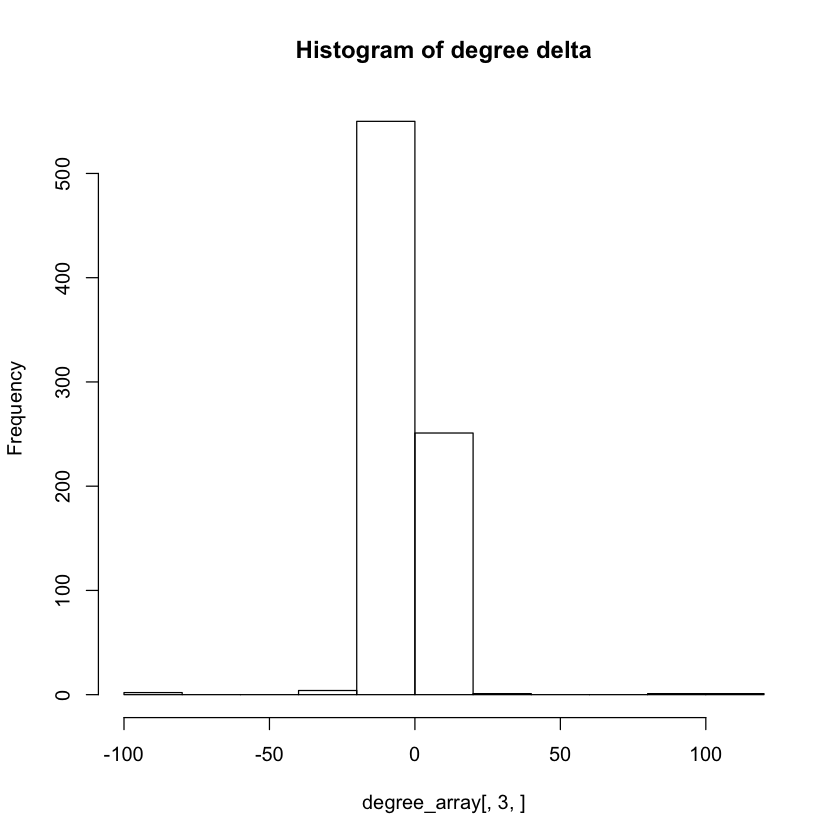

[1] "Warning: some graphs are not assigned to any cluster"
[1] "We have 8 clusters"
List of 3
 $ dissim_matrix          : num [1:162, 1:162] 0 1 1 1 1 1 1 1 1 1 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:162] "WNT5A:FZD6" "NRG1:NETO2" "EFNB1:EPHB2" "EPHB2:EFNB3" ...
  .. ..$ : chr [1:162] "WNT5A:FZD6" "NRG1:NETO2" "EFNB1:EPHB2" "EPHB2:EFNB3" ...
 $ clusters               : Named num [1:162] 4 2 2 1 4 2 1 5 3 1 ...
  ..- attr(*, "names")= chr [1:162] "WNT5A:FZD6" "NRG1:NETO2" "EFNB1:EPHB2" "EPHB2:EFNB3" ...
 $ weight_array_by_cluster: num [1:5, 1:5, 1:8] 0.0973 0.2163 0.3269 0.0455 0.0264 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:5] "EPI" "Mes" "TE" "emVE" ...
  .. ..$ : chr [1:5] "EPI" "Mes" "TE" "emVE" ...
  .. ..$ : chr [1:8] "cluster 1" "cluster 2" "cluster 3" "cluster 4" ...
NULL


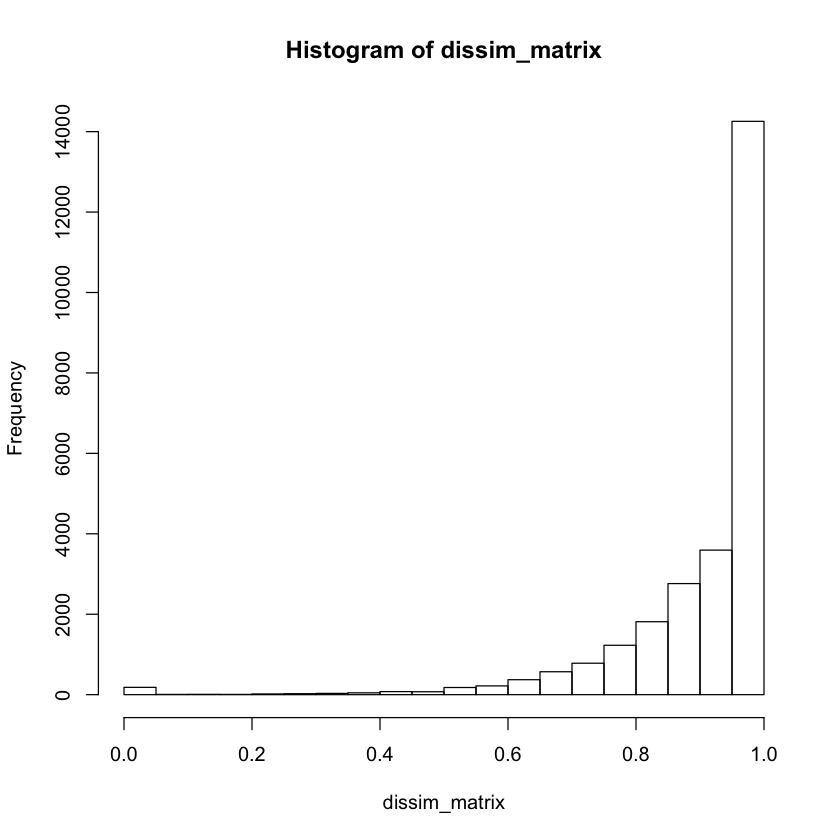

In [9]:
# run communication clusters analysis
lrp_clusters <- lrp_clustering(weight_array = interactions$weight_array
                               ,ligand_receptor_pair_df = interactions$ligand_receptor_pair_df
                               ,nodes = interactions$nodes
                              )
print(str(lrp_clusters))

In this data set, we detected 8 clusters.

### Visualization

We can now plot the heatmap and the UMAP of the clustered ligand-receptor pairs.

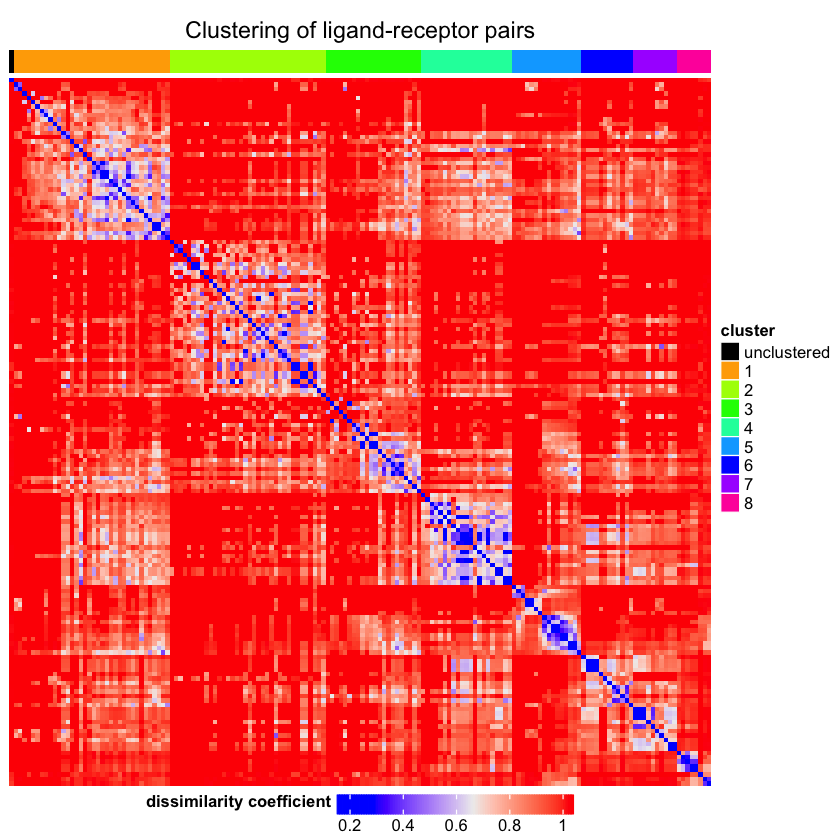

In [10]:
# plot heatmap
plot_cluster_heatmap(dissim_matrix = lrp_clusters$dissim_matrix
                    ,lrp_clusters = lrp_clusters$clusters
                    )

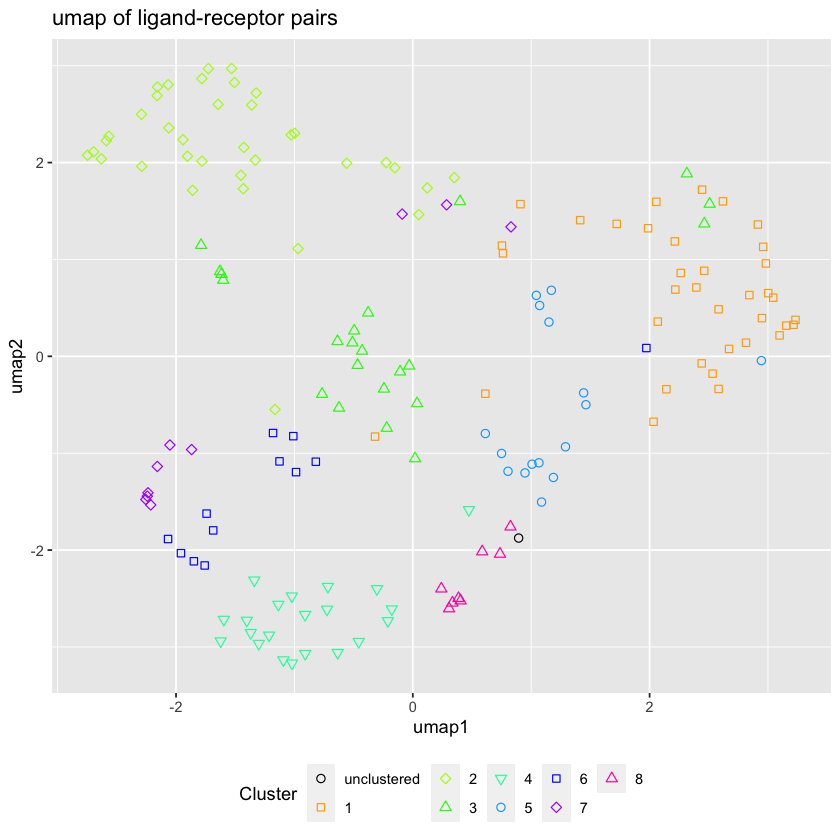

In [12]:
# plot umap of ligand-receptor pairs
plot_cluster_UMAP(ligand_receptor_pair_df = interactions$ligand_receptor_pair_df
                  ,dissim_matrix = lrp_clusters$dissim_matrix
                  ,lrp_clusters = lrp_clusters$clusters
                 )

We can as well plot the average communication pattern of the first three clusters

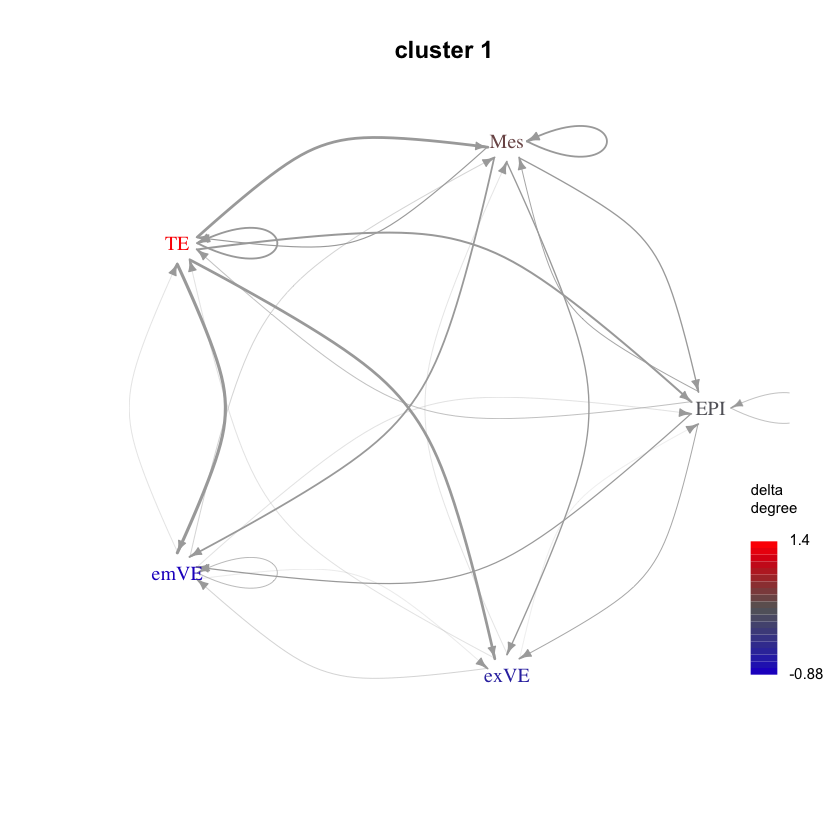

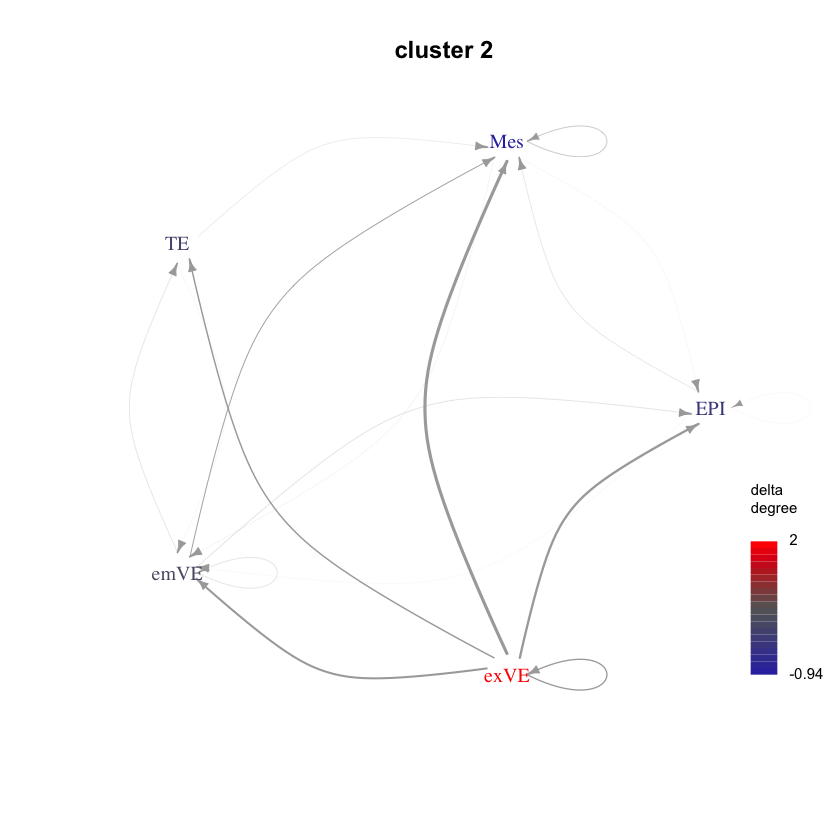

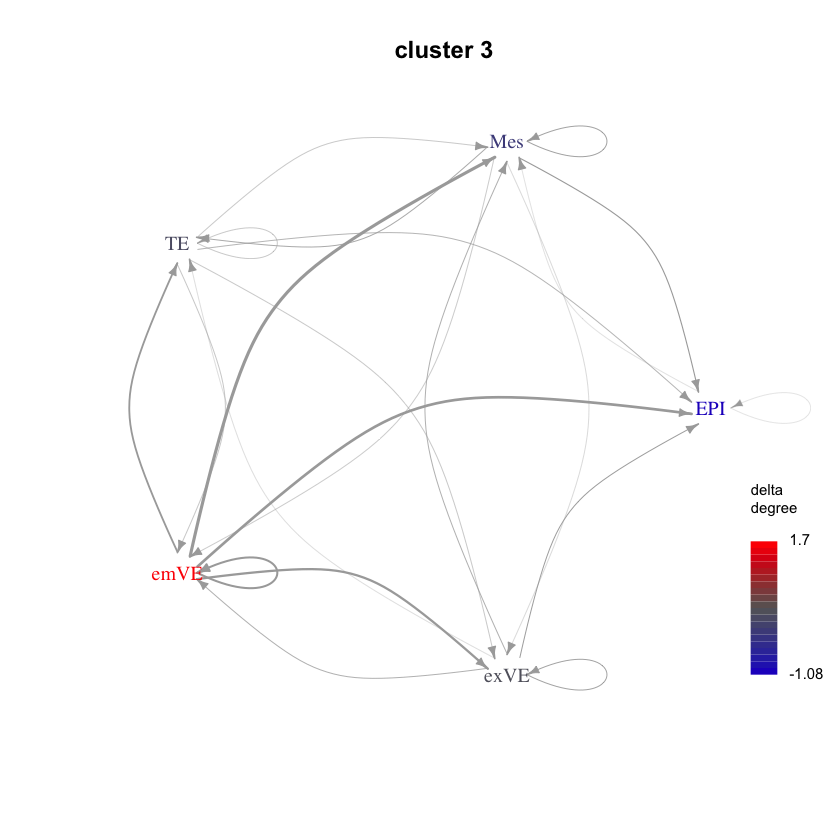

In [13]:
# plot communication plots for clusters (first three clusters)
for(clusterNr in c(1:3)){
    cluster  <-  paste("cluster"
                      ,clusterNr)
    plot_communication_graph(LRP = cluster
                       ,weight_array = lrp_clusters$weight_array_by_cluster[,,cluster]
                       ,ligand_receptor_pair_df = interactions$ligand_receptor_pair_df
                       ,nodes = interactions$nodes
                       ,is_cluster = T
                      )
}


We see that the first cluster represents a communication pattern where TE is preferentially sending signals to other cell types. In cluster 2, exVE is preferentially sending signals, and in cluster 3 emVE is sending signals.

It is worth noting here that if you are interested in a "family" of particular ligand-receptor pairs, which are not identified as a separate cluster by COMUNET, you can still plot a communication graph of this family by passing the family weight array as ```weight_array``` parameter as setting ```is_cluster = TURE``` to the ```plot_communication_graph``` funciton. One of the ways to calculate the family weight array could be to take an average value for each edge.

As the last step, let us inspect, which ligand-receptor pairs are present in the (first three) clusters.

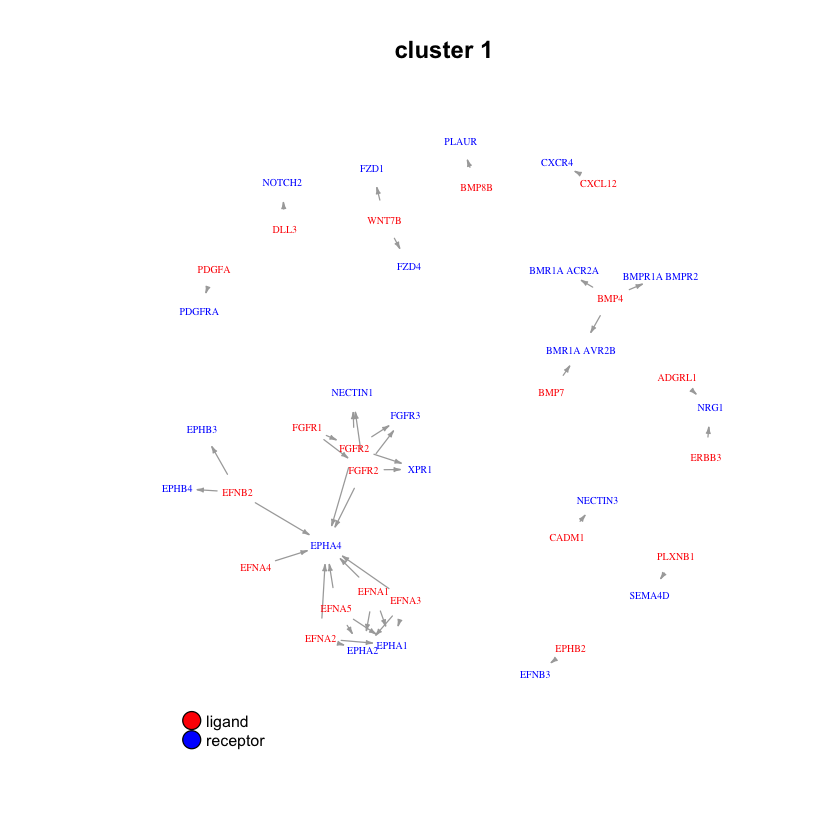

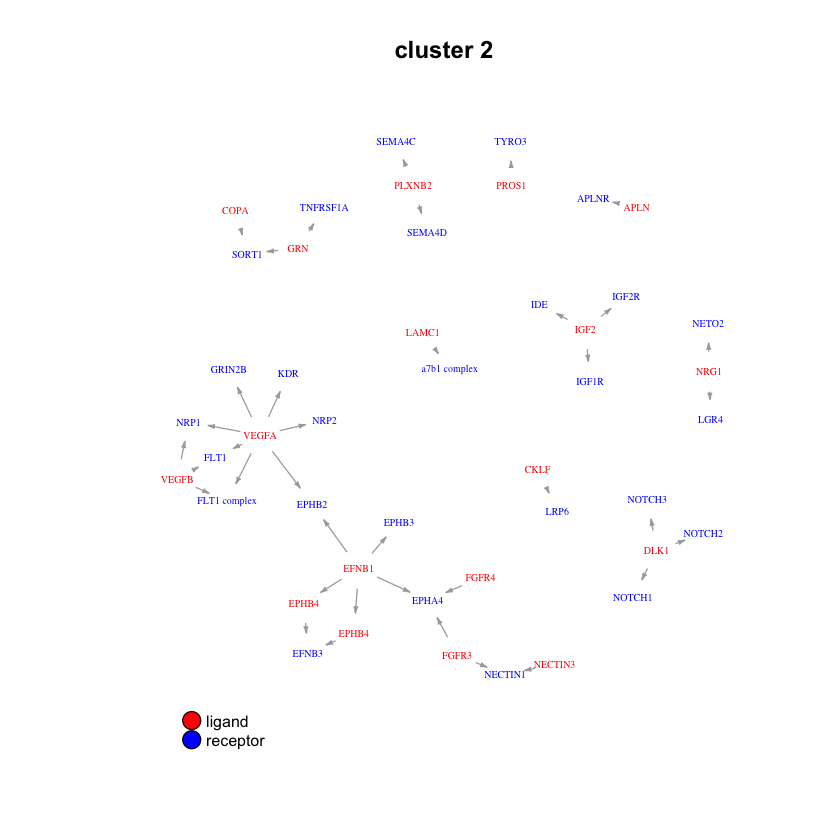

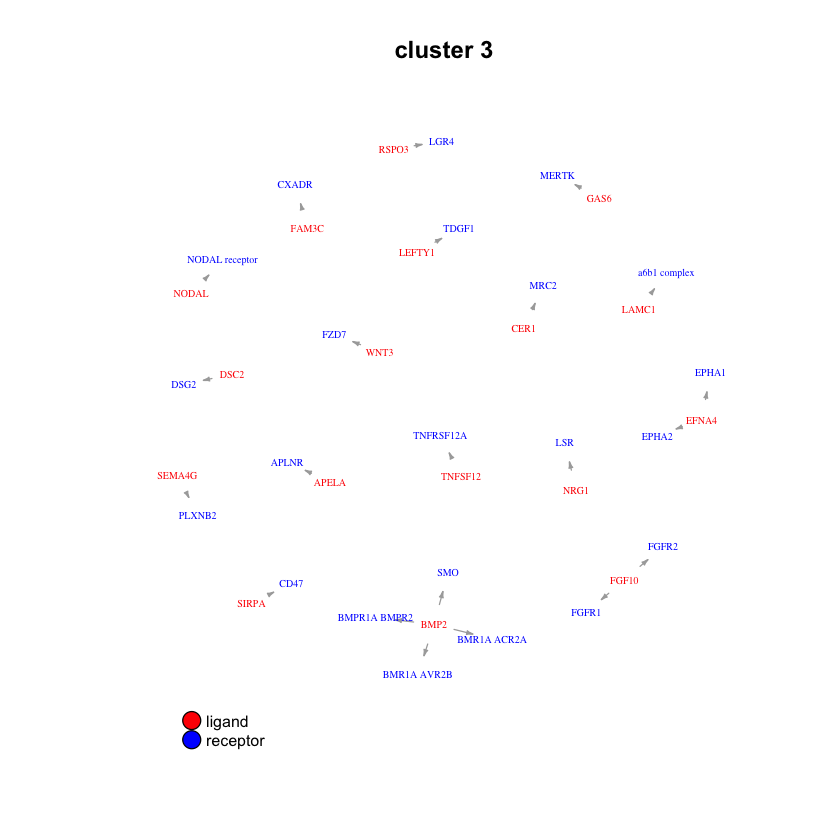

In [14]:
# plot ligand-receptor pairs in each cluster (first three clusters)
for(clusterNr in c(1:3)){
    plot_lig_rec(cluster_of_interest = clusterNr
                 ,lrp_clusters = lrp_clusters$clusters
                 ,ligand_receptor_pair_df = interactions$ligand_receptor_pair_df
                 ,node_label_cex = 0.5
          )
}
